In [1]:
## imports
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

from scipy.optimize import minimize 
from scipy.interpolate import griddata
import math
from typing import Union

In [2]:
## qiskit import
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer, transpile
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem, AmplificationProblem, Grover, GroverResult, AmplitudeAmplifier
from qiskit.circuit.library import LinearAmplitudeFunction, LinearPauliRotations, PiecewiseLinearPauliRotations, WeightedAdder, GroverOperator
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector


In [5]:
## IBM setup ~
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
# IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
# construct circuit for uncertainty modeler.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [6]:
## helper fucntions ~
def str_to_oracle(pattern: str, name= 'oracle', return_type = "QuantumCircuit" ) -> Union[QuantumCircuit,  Statevector] :
    """ Convert a given string to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle_circuit    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    oracle_circuit = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]=='0'): oracle_circuit.x(qr[q])
    oracle_circuit.x(a)
    oracle_circuit.h(a)
    oracle_circuit.mcx(qr, a)
    oracle_circuit.h(a)
    oracle_circuit.x(a)
    for q in range(l):
        if(pattern[q]=='0'): oracle_circuit.x(qr[q])
    
    #oracle_circuit.barrier()
    if return_type == "QuantumCircuit":
        return oracle_circuit


## Variational Quantum Amplitude Estimation Algorithm 
Here we try to implement QAE based on variational quantum circuits as discussed in the paper <insert link >. 

### Step:
Designning a variational circuit to implement $\mathcal{Q}^k$ on a given initial state, where $\mathcal{Q}$ is the grover operator composed as 
$ \mathcal{Q} = - (\mathbb{I} - 2 P_{\psi_0})(\mathbb{I} - 2 P_{good})$. The variational circuit will be constructed out of paramterised $R_y$ gates and $CX$ gates, as discussed in the original paper. 

For implementation we will use pre-defined functions such as  ```AmplificationProblem```, ```Grover``` , ```GroverOperator``` from ```qiskit.circuit.library``` and ```qiskit.algorithms``` module.

##### #2 qubit states

In [7]:
## init ~
good_states = ['10']
n = len(good_states[0])
initial_state = None

## oracle prep ~
oracles = [ str_to_oracle(good_state) for good_state in good_states ]
oracle_circuit = oracles[0]
for oracle in oracles[1:] :
    oracle_circuit.compose(oracle,  inplace= True)

## create grover operator ~
grover_operator = GroverOperator(oracle_circuit, name= "Grover", insert_barriers= False)

In [8]:
def state_prep_circuit(n):
    qreg = QuantumRegister(n)
    state_prep_circuit = QuantumCircuit(qreg, name = "state_prep")
    state_prep_circuit.h(qreg)

    return state_prep_circuit

In [9]:
state_prep_circuit(2).draw()

┌───┐
q0_0: ┤ H ├
      ├───┤
q0_1: ┤ H ├
      └───┘

In [10]:
## variational circuit preparation ~
def var_prep_circuit(n , var_params_input= 'random' , num_var_params= 4):

    qreg = QuantumRegister(n, name= 'qreg')
    var_circuit = QuantumCircuit(qreg, name= "Var_"+str(n))
    
    if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)
    else: var_params = var_params_input
    
    var_circuit.ry(var_params[0], qreg[1] )
    var_circuit.cx(1,0)
    var_circuit.ry(var_params[1], qreg[1])
    var_circuit.ry(var_params[2], qreg[0])
    var_circuit.cx(1,0)
    var_circuit.ry(var_params[3], qreg[1])

    return var_circuit


3

In [11]:
var_prep_circuit(2).draw(), grover_operator.draw()

(                      ┌───┐┌────────────┐┌───┐              
 qreg_0: ──────────────┤ X ├┤ Ry(5.7037) ├┤ X ├──────────────
         ┌────────────┐└─┬─┘├────────────┤└─┬─┘┌────────────┐
 qreg_1: ┤ Ry(5.0109) ├──■──┤ Ry(5.4405) ├──■──┤ Ry(4.2415) ├
         └────────────┘     └────────────┘     └────────────┘,
          ┌────┐
 state_0: ┤0   ├
          │    │
 state_1: ┤1 Q ├
          │    │
 ancilla: ┤2   ├
          └────┘)

In [12]:
## optimisation step ~
def objective(var_params , state_prep_circuit , var_prep_circuit,  grover_circuit, shots= 1024):
    
    num_state_qubits = grover_circuit.num_qubits - grover_circuit.num_ancillas
    qc = state_prep_circuit(num_state_qubits)
    state_prep_circuit_var = qc.copy()
    state_prep_circuit_grover = qc.copy()

    ## var ~
    var_circuit = var_prep_circuit(num_state_qubits, var_params_input= var_params )
    state_prep_circuit_var.compose( var_circuit, inplace= True )
    
    ## grover ~
    num_ancillas=  grover_circuit.num_ancillas
    ancilla = AncillaRegister(num_ancillas, name= 'ancilla')
    state_prep_circuit_grover.add_register(ancilla)
    state_prep_circuit_grover.compose( grover_circuit, inplace= True)

    ## measure fidelity using 'Statevector' method ~
    var_statevector = Statevector.from_instruction(state_prep_circuit_var)
    grover_statevector = partial_trace(Statevector.from_instruction(state_prep_circuit_grover), [2] ).to_statevector()
    
    fidelity = np.real(var_statevector.inner(grover_statevector))

    return fidelity

In [13]:
num_var_params = 4
var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)
optimisation_result = minimize(objective, var_params, (state_prep_circuit, var_prep_circuit, grover_operator), 'COBYLA')

/tmp/ipykernel_22642/1409384494.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)


In [14]:
optimisation_result

     fun: -0.9999999993977822
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 71
  status: 1
 success: True
       x: array([4.72224052, 3.13173435, 4.71235071, 3.14165017])

In [28]:
def test_var_vs_grover(var_params , state_prep_circuit , var_prep_circuit,  grover_operator, shots= 1024):
    """ fucntion to compare the performace of the varriational circuit with the grover circuit """
    
    num_state_qubits = grover_operator.num_qubits - grover_operator.num_ancillas
    creg = ClassicalRegister(num_state_qubits, name= 'creg' )

    qc = state_prep_circuit(num_state_qubits)
    state_prep_circuit_var = qc.copy()
    state_prep_circuit_grover = qc.copy()

    ## var ~
    var_circuit = var_prep_circuit(num_state_qubits, var_params_input= var_params )
    state_prep_circuit_var.compose( var_circuit, inplace= True )
    state_prep_circuit_var.measure_all()

    var_counts = execute(state_prep_circuit_var, backend= qsm, shots= 1024).result().get_counts()

    ## grover ~
    num_ancillas=  grover_operator.num_ancillas
    qreg_grover = QuantumRegister(num_state_qubits, name= 'qreg')
    state_prep_circuit_grover = QuantumCircuit(qreg_grover).compose(state_prep_circuit_grover)
    ancilla = AncillaRegister(num_ancillas, name= 'ancilla')
    creg = ClassicalRegister(num_state_qubits, name= 'creg')
    state_prep_circuit_grover.add_register(ancilla)
    state_prep_circuit_grover.add_register(creg)
    state_prep_circuit_grover.compose( grover_operator, inplace= True)
    state_prep_circuit_grover.measure(qreg_grover, creg )

    grover_counts = execute(state_prep_circuit_grover, backend= qsm, shots= 1024).result().get_counts()

    ## plot histogram ~
    return plot_histogram([grover_counts, var_counts], figsize= (15,8), legend= ['grover', 'variatonal'], title= 'Comparison')


/tmp/ipykernel_22642/1409384494.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)


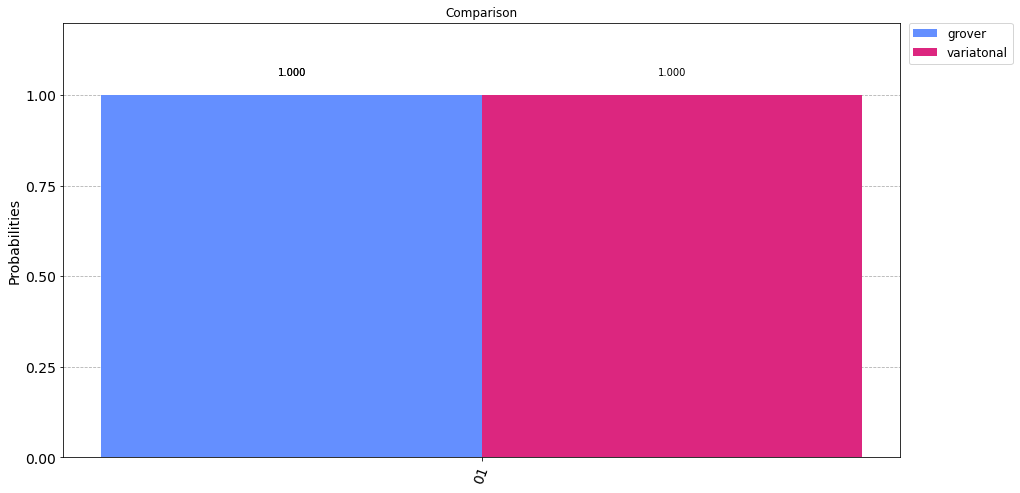

In [29]:
test_var_vs_grover(optimisation_result.x, state_prep_circuit, var_prep_circuit, grover_operator)

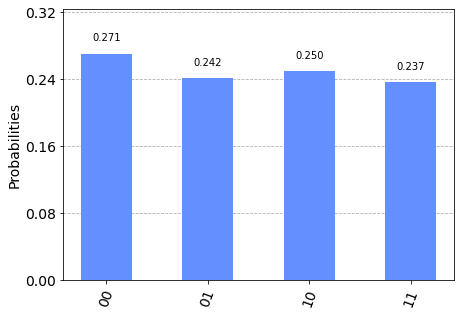

In [9]:
creg = ClassicalRegister(2,name= 'creg_grover')
grover_operator.add_register(creg)
grover_operator.measure(0, creg[0])
grover_operator.measure(1, creg[1])
plot_histogram(execute(grover_operator, backend= qsm ).result().get_counts())


#### #6 qubit states

In [7]:
## variational circuit preparation ~
n_state = len(good_states[0])
qc  = QuantumCircuit(n_state) 

In [8]:
grover_operator.decompose().draw()

global phase: π
                        ┌───┐┌───┐               ┌───┐┌───┐     
state_0: ────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
         ┌───┐       │  ├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐
state_1: ┤ X ├───────■──┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         ├───┤┌───┐┌─┴─┐├───┤├───┤└───┘└───┘└───┘└───┘└───┘└───┘
ancilla: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├──────────────────────────────
         └───┘└───┘└───┘└───┘└───┘